
##### Copyright 2019 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");





In [0]:
# Copyright 2019 Google LLC. All Rights Reserved.

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# DDSP Core Functions Demo

This notebook provides some simple demonstrations of using DDSP primitives for synthesis, filtering, and interpolation. Keep in mind that all of components are fully differentiable and can be integrated with neural networks and end-2-end learning. Synthesizer and Effect Processors are built around these central components.

# Imports

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from colabtools import sound
import ddsp
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

tf.disable_v2_behavior()

# Helper Functions 
sess = tf.compat.v1.InteractiveSession()
sample_rate = 16000
play = lambda x: sound.Play(x, sample_rate)
f32 = ddsp.core.f32

def specplot(audio, vmin=-5, vmax=1, rotate=True, size=512 + 256):
  logmag = ddsp.spectral_ops.calc_logmag(f32(audio), size=size).eval()
  if rotate:
    logmag = np.rot90(logmag)
  plt.matshow(logmag, vmin=vmin, vmax=vmax, cmap=plt.cm.magma, aspect='auto')
  plt.xticks([])
  plt.yticks([])

def transfer_function(ir, sample_rate=16000):
  """Get true transfer function from an impulse_response."""
  n_fft = ddsp.core.get_fft_size(0, ir.shape.as_list()[-1])
  frequencies = np.abs(np.fft.fftfreq(n_fft, 1/sample_rate)[:int(n_fft/2) + 1])
  magnitudes = tf.abs(tf.signal.rfft(ir, [n_fft]))
  return frequencies, magnitudes


def plot_impulse_responses(impulse_response,  
                           desired_magnitudes,
                           sample_rate=16000):
  n_fft = desired_magnitudes.shape[-1] * 2
  frequencies = np.fft.fftfreq(n_fft, 1/sample_rate)[:n_fft//2]

  plt.figure(figsize=(12, 6))
  plt.subplot(121)
  # Desired transfer function.
  plt.semilogy(frequencies, desired_magnitudes, label='Desired')
  # True transfer function.
  true_frequencies, true_magnitudes = transfer_function(impulse_response)
  plt.semilogy(true_frequencies, true_magnitudes.eval()[0, 0, :], label='True')
  plt.title('Transfer Function')
  plt.legend()

  plt.subplot(122)
  plt.plot(impulse_response.eval()[0, 0, :])
  plt.title('Impulse Response')

# Filtering


Time-varying differentiable linear filters (parameterized in frequency space). Impulse responses are designed by `sinc_impulse_response()` and `frequency_impulse_reponse()` and then applied by `fft_convolve()`. 

`sinc_filter()` and `frequency_filter()` are thin wrappers around filter design and `fft_convolve()`.

---

## `fft_convolve()`


Time-varying filter. Given audio [batch, n_samples], and a series of impulse responses [batch, n_frames, n_impulse_response], splits the audio into frames, applies filters, and then overlap-and-adds audio back together. 

#### Ex: Low-pass sweep

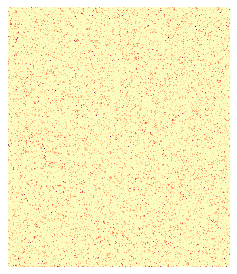

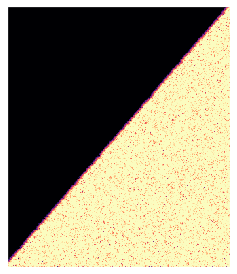

In [0]:
## Low-pass sweep in Hertz.
sample_rate = 16000
nosie = f32(np.random.uniform(-0.5, 0.5, [1, sample_rate *4]))
f_cutoff = np.linspace(0., 1.0, 200)[np.newaxis, :, np.newaxis]

ir = ddsp.sinc_impulse_response(f_cutoff , 2048)
filtered = ddsp.fft_convolve(nosie, ir)

noise_np, filtered_np = nosie.eval(), filtered.eval()
specplot(noise_np[0])
specplot(filtered_np[0])
play(noise_np[0])
play(filtered_np[0])

## `sinc_impulse_response()`


Simple FIR low-pass filter design using sinc functions.

### Ex: Brick-wall filter


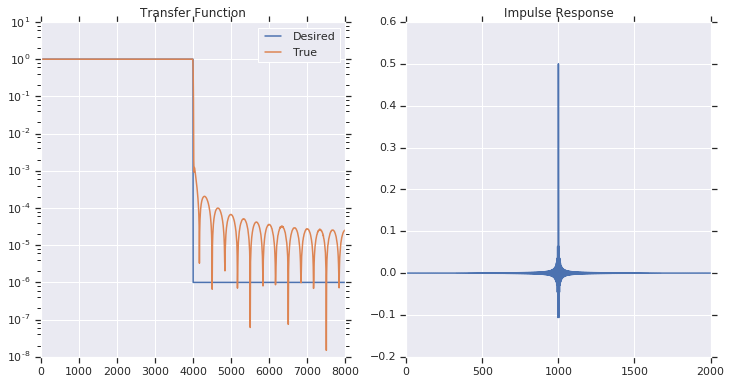

In [0]:
# Brick-wall filter
sample_rate = 16000
f_cutoff = f32([4000])[tf.newaxis, tf.newaxis, :]
window_size = 2000

# True filter.
impulse_response = ddsp.sinc_impulse_response(f_cutoff, window_size, sample_rate)

# Ideal brick-wall filter
half_nyquist = int(window_size / 2)
desired_magnitudes = np.concatenate([np.ones([half_nyquist]), 
                                     np.zeros([half_nyquist]) + 1e-6], axis=0) 

plot_impulse_responses(impulse_response, desired_magnitudes)

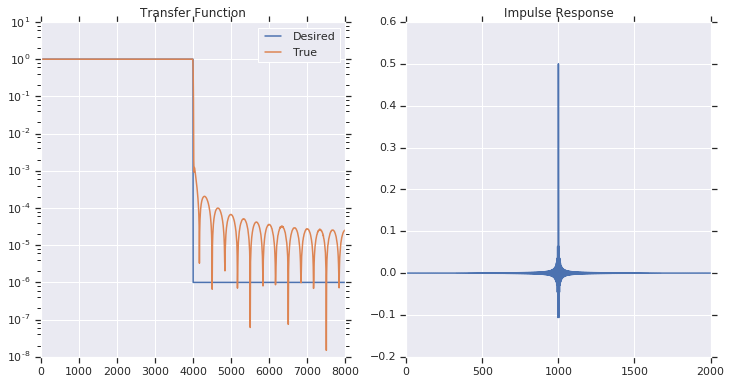

In [0]:
## Normalized frequency [0, 1] works as well, without needing sample_rate.
f_cutoff = f32([0.5])[tf.newaxis, tf.newaxis, :]

# True filter.
impulse_response = ddsp.sinc_impulse_response(f_cutoff, window_size)

plot_impulse_responses(impulse_response, desired_magnitudes)

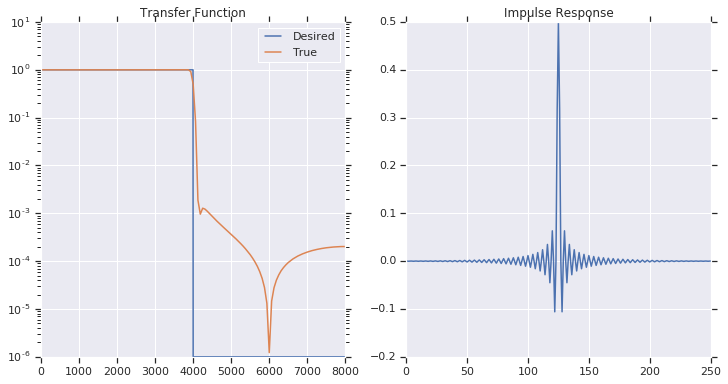

In [0]:
# Changing window size changes the time-frequency characteristics.
impulse_response = ddsp.sinc_impulse_response(f_cutoff, window_size=250)

plot_impulse_responses(impulse_response, desired_magnitudes)

## `sinc_filter()`


Thin wrapper around `sinc_impulse_response()` and `fft_convolve`. Filter audio with a low-pass filter.


### Ex: Bandlimited Upsampling

Let's start with a triangle wave at 100 Hz, sampled at 10kHz.

Original


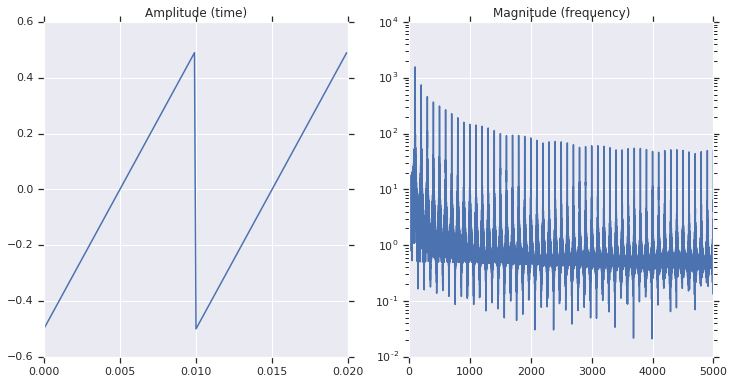

In [0]:
sample_rate = 10000
n_samples = sample_rate + 1

# Let's start with a triangle wave at 100 Hz.
time = tf.linspace(0.0, 1.0, n_samples)
signal = (tf.linspace(0.0, 100.0, n_samples) % 1.0) - 0.5

# Look at FFT of signal.
frequencies, magnitudes = transfer_function(signal[tf.newaxis, tf.newaxis, :],
                                            sample_rate=sample_rate)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(time[:200].eval(), signal[:200].eval())
plt.title('Amplitude (time)')
plt.subplot(122)
plt.semilogy(frequencies, magnitudes.eval()[0, 0, :])
plt.title('Magnitude (frequency)')

print('Original')
sound.Play(signal.eval(), sample_rate=sample_rate)

If we naively double the sample rate to 20kHz, we introduce upsampling artifacts.

Box upsample


Bilinear upsample


Original


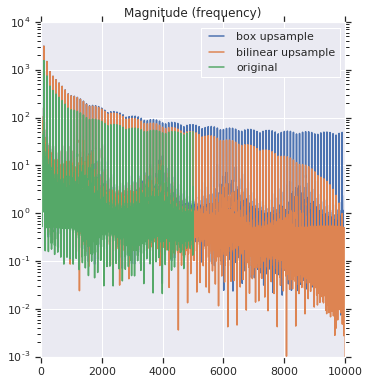

In [0]:
upsample = 2
upsample_rate = int(sample_rate * upsample)
n_upsample = int(n_samples * upsample)

time_up = tf.linspace(0.0, 1.0, n_upsample)

# Box upsampling
signal_up = tf.image.resize_nearest_neighbor(
    signal[tf.newaxis, :, tf.newaxis, tf.newaxis], [n_upsample, 1]
    )[0, :, 0, 0]
frequencies_up, magnitudes_up = transfer_function(signal_up[tf.newaxis, tf.newaxis, :],
                                                      sample_rate=upsample_rate)

# Bilinear upsampling
signal_up_bl = ddsp.resample(signal[tf.newaxis, :, tf.newaxis], n_upsample)[0, :, 0]
frequencies_up_bl, magnitudes_up_bl = transfer_function(signal_up_bl[tf.newaxis, tf.newaxis, :],
                                                        sample_rate=upsample_rate)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.semilogy(frequencies_up, magnitudes_up.eval()[0, 0, :], label='box upsample')
plt.semilogy(frequencies_up_bl, magnitudes_up_bl.eval()[0, 0, :], label='bilinear upsample')
plt.semilogy(frequencies, magnitudes.eval()[0, 0, :], label='original')
plt.ylim(1e-3, 1e4)
plt.title('Magnitude (frequency)')
plt.legend()

print('Box upsample')
sound.Play(signal_up.eval(), sample_rate=upsample_rate)
print('Bilinear upsample')
sound.Play(signal_up_bl.eval(), sample_rate=upsample_rate)
print('Original')
sound.Play(signal.eval(), sample_rate=sample_rate)

By applying a brick-wall low-pass filter as above, we can remove aliasing artifacts.

Box upsample


Anti-aliased


Original


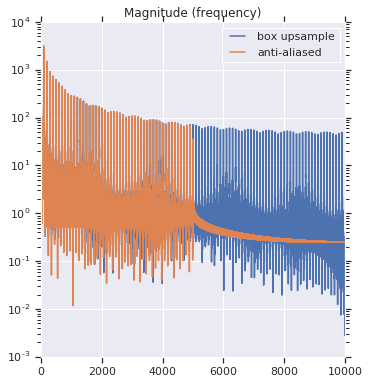

In [0]:
n_frequencies = 1024
half_nyquist = int(n_frequencies / 2)

# Bandpass filters, [n_batch, n_frames, n_frequencies].
cutoff_frequency = tf.ones([1, 1, 1]) * 0.5 

signal_filt = ddsp.sinc_filter(signal_up[tf.newaxis, :],
                               cutoff_frequency,
                               window_size=1024)[0]

frequencies_filt, magnitudes_filt = transfer_function(signal_filt[tf.newaxis, tf.newaxis, :],
                                                      sample_rate=upsample_rate)


plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.semilogy(frequencies_up, magnitudes_up.eval()[0, 0, :], label='box upsample')
plt.semilogy(frequencies_filt, magnitudes_filt.eval()[0, 0, :], label='anti-aliased')
plt.ylim(1e-3, 1e4)
plt.title('Magnitude (frequency)')
plt.legend()

print('Box upsample')
sound.Play(signal_up.eval(), sample_rate=upsample_rate)
print('Anti-aliased')
sound.Play(signal_filt.eval(), sample_rate=upsample_rate)
print('Original')
sound.Play(signal.eval(), sample_rate=sample_rate)


## `frequency_impulse_response()`


FIR filter design method used by `ddsp.frequency_filter()`. Uses the frequency sampling method of filter design as described [here]( https://ccrma.stanford.edu/~jos/sasp/Windowing_Desired_Impulse_Response.html).

### Ex: Arbitrary filter design


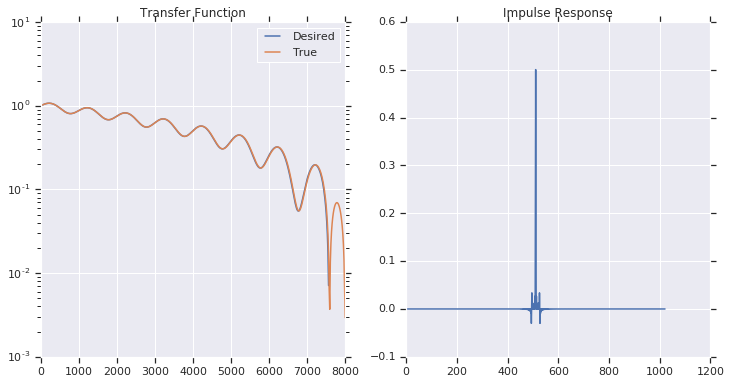

In [0]:
# Brick-wall filter
sample_rate = 16000
n_frequencies = 512
half_nyquist = int(n_frequencies / 2)

# Bandpass filters, [n_batch, n_frames, n_frequencies].
magnitudes = (tf.linspace(1.0, 0.001, n_frequencies) + 
              0.1 * tf.sin(tf.linspace(0.0, 2.0 * np.pi * 8, n_frequencies)))
magnitudes = magnitudes[tf.newaxis, tf.newaxis, :]
desired_magnitudes = magnitudes.eval()[0, 0, :]

# Designed filter.
impulse_response = ddsp.frequency_impulse_response(magnitudes, window_size=0)

plot_impulse_responses(impulse_response, desired_magnitudes)

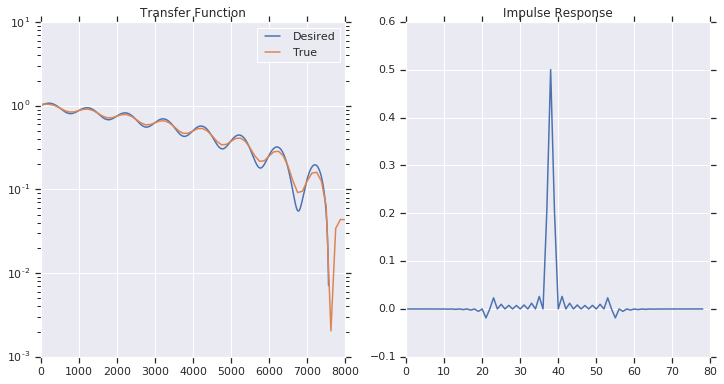

In [0]:
# Changing window size changes the time-frequency characteristics.
impulse_response = ddsp.frequency_impulse_response(magnitudes, window_size=80)

plot_impulse_responses(impulse_response, desired_magnitudes)

## `frequency_filter()`



Thin wrapper around `frequency_impulse_response()` and `fft_convolve`. Filter audio with a finite impulse response linear time-varying filter, designed using the frequency sampling method.


### Ex: Arbitrary time-varying filter

Let's try a time-invariant filter. The `magnitudes` have a single frame and `n_frequency` bands linearly spaced between 0 and Nyquist.

Original


Filtered


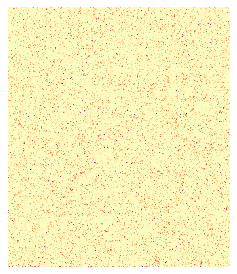

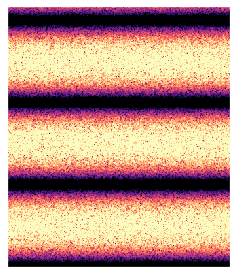

In [0]:
sample_rate = 16000
n_samples = int(sample_rate * 4.0)
n_frequencies = 1000

# White noise.
audio_in = tf.random_uniform([1, n_samples], -0.5, 0.5)

# Bandpass filters, [n_batch, n_frames, n_frequencies].
magnitudes = tf.sin(tf.linspace(0.0, 10.0, n_frequencies))**4.0
magnitudes = magnitudes[tf.newaxis, tf.newaxis, :]

# Filter.
audio_out = ddsp.frequency_filter(audio_in, magnitudes)

# Listen.
audio_in_np = audio_in.eval()[0, :]
audio_out_np = audio_out.eval()[0, :]

print('Original')
play(audio_in_np)
specplot(audio_in_np)

print('Filtered')
play(audio_out_np)
specplot(audio_out_np)

`ddsp.fir_filter()` uses the frequency sampling method of filter design as described [here]( https://ccrma.stanford.edu/~jos/sasp/Windowing_Desired_Impulse_Response.html).

Reducing `n_frequencies` thus reduces frequency resolution.

`window_size` crops the impulse responses to also determine the time-frequency tradeoff.
`window_size` must be > the fft_size which is the power of 2 >= `n_frequencies` * 2.
Setting `window_size` < 1, automatically sets it at `n_frequencies`.


Less frequency resolution


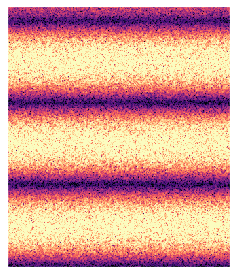

In [0]:
# Fewer frequencies, less frequency resolution.
n_frequencies = 32

# Bandpass filters, [n_batch, n_frames, n_frequencies].
magnitudes = tf.sin(tf.linspace(0.0, 10.0, n_frequencies))**4.0
magnitudes = magnitudes[tf.newaxis, tf.newaxis, :]

# Filter.
audio_out = ddsp.frequency_filter(audio_in, magnitudes, window_size=0)

# Listen.
audio_out_np = audio_out.eval()[0, :]
print('Less frequency resolution')
play(audio_out_np)
specplot(audio_out_np)

Smaller window


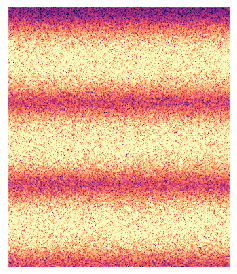

In [0]:
# Smaller window_size, less frequency resolution (more temporal resolution).
n_frequencies = 1000

# Bandpass filters, [n_batch, n_frames, n_frequencies].
magnitudes = tf.sin(tf.linspace(0.0, 10.0, n_frequencies))**4.0
magnitudes = magnitudes[tf.newaxis, tf.newaxis, :]

# Filter.
audio_out = ddsp.frequency_filter(audio_in, magnitudes, window_size=32)

# Listen.
audio_out_np = audio_out.eval()[0, :]
print('Smaller window')
play(audio_out_np)
specplot(audio_out_np)

Time-varying Filter


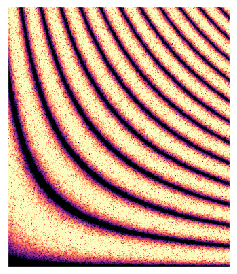

In [0]:
# Now let's try a time-varying filter.
n_frames = 250
n_frequencies = 1000

# Bandpass filters, [n_batch, n_frames, n_frequencies].
magnitudes = [tf.sin(tf.linspace(0.0, w, n_frequencies))**4.0 for w in np.linspace(4.0, 40.0, n_frames)]
magnitudes = tf.stack(magnitudes)
magnitudes = magnitudes[tf.newaxis, :, :]

# Filter.
audio_out = ddsp.frequency_filter(audio_in, magnitudes)

# Listen.
audio_out_np = audio_out.eval()[0, :]
print('Time-varying Filter')
play(audio_out_np)
specplot(audio_out_np)

Time-varying Filter, Low temporal resolution


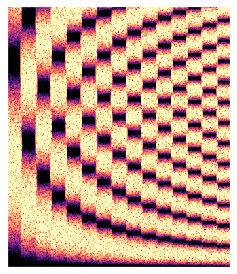

In [0]:
# The filter equally spaces the frames in time, so if you don't have enough, you'll hear transitions.
n_frames = 15

# Bandpass filters, [n_batch, n_frames, n_frequencies].
magnitudes = [tf.sin(tf.linspace(0.0, w, n_frequencies))**4.0 for w in np.linspace(4.0, 40.0, n_frames)]
magnitudes = tf.stack(magnitudes)
magnitudes = magnitudes[tf.newaxis, :, :]

# Filter.
audio_out = ddsp.frequency_filter(audio_in, magnitudes)

# Listen.
audio_out_np = audio_out.eval()[0, :]
print('Time-varying Filter, Low temporal resolution')
play(audio_out_np)
specplot(audio_out_np)

# Resampling

Many functions require controls to be provided at the audio sample rate, but often one will want the network to output controls at a coarser rate.

## `resample()`


Simple bilinear upsampling of control signal based on `tf.image.resize()`.

With `add_endpoint=False`, uses the last timestep as the endpoint, producing `n_frames - 1` segments, each with a length of `n_timesteps / (n_frames - 1)`.


(-0.1, 1.1)

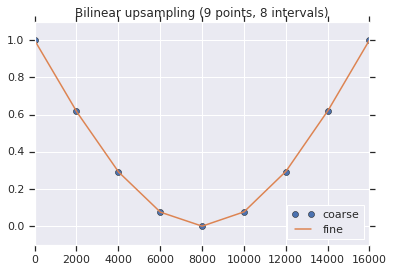

In [0]:
n_coarse = 9
n_fine = 16000

coarse = 1.0 - np.sin(np.linspace(0, np.pi, n_coarse))[np.newaxis, :, np.newaxis]
fine = ddsp.resample(coarse, n_fine, add_endpoint=False)

plt.plot(np.linspace(0, n_fine, n_coarse), coarse[0, :, 0], 'o', label='coarse')
plt.plot(np.linspace(0, n_fine, n_fine), fine.eval()[0, :, 0], label='fine')
plt.title('Bilinear upsampling ({} points, {} intervals)'.format(n_coarse, n_coarse - 1))
plt.legend(loc='lower right')
plt.ylim(-0.1, 1.1)

With `add_endpoint=True`, holds the last timestep for an additional step as the endpoint. 
Then, `n_timesteps` is divided evenly into `n_frames` segments of size `n_timesteps / n_frames`. This is the default behavior, as it matches the default behavior of `fft_convolve`.

(-0.1, 1.1)

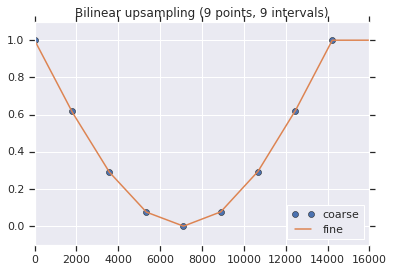

In [0]:
fine = ddsp.resample(coarse, n_fine)

n_adjusted = int(n_fine / n_coarse * (n_coarse - 1))
plt.plot(np.linspace(0, n_adjusted, n_coarse), coarse[0, :, 0], 'o', label='coarse')
plt.plot(np.linspace(0, n_fine, n_fine), fine.eval()[0, :, 0], label='fine')
plt.title('Bilinear upsampling ({} points, {} intervals)'.format(n_coarse, n_coarse))
plt.legend(loc='lower right')
plt.ylim(-0.1, 1.1)

You can also do cubic interpolation

(-0.1, 1.1)

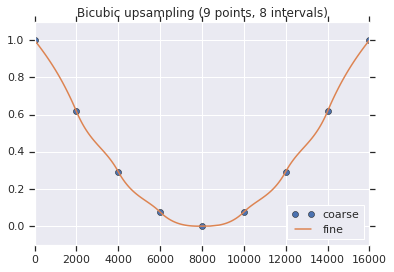

In [0]:
fine = ddsp.resample(coarse, n_fine, method='cubic', add_endpoint=False)

plt.plot(np.linspace(0, n_fine, n_coarse), coarse[0, :, 0], 'o', label='coarse')
plt.plot(np.linspace(0, n_fine, n_fine), fine.eval()[0, :, 0], label='fine')
plt.title('Bicubic upsampling ({} points, {} intervals)'.format(n_coarse, n_coarse - 1))
plt.legend(loc='lower right')
plt.ylim(-0.1, 1.1)

Resampling also works for downsampling

(-0.1, 1.1)

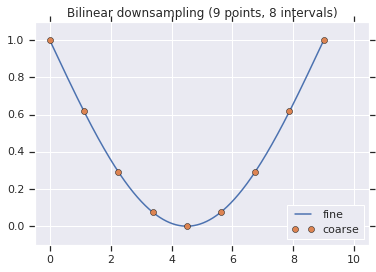

In [0]:
n_coarse = 9
n_fine = 16000

fine = 1.0 - np.sin(np.linspace(0, np.pi, n_fine))[np.newaxis, :, np.newaxis]
coarse = ddsp.resample(fine, n_coarse, add_endpoint=False)

plt.plot(np.linspace(0, n_coarse, n_fine), fine[0, :, 0],  label='fine')
plt.plot(np.linspace(0, n_coarse, n_coarse), coarse.eval()[0, :, 0], 'o', label='coarse')
plt.title('Bilinear downsampling ({} points, {} intervals)'.format(n_coarse, n_coarse - 1))
plt.legend(loc='lower right')
plt.xlim(-0.5, 10.5)
plt.ylim(-0.1, 1.1)

For downsampling add endpoint interpolates up to an added endpoint, which actually removes an endpoint from the downsampled signal. This still results in the same number of points and segments.

(-0.1, 1.1)

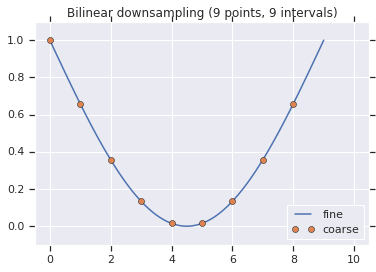

In [0]:
n_intervals = (n_fine - 1)
n_forward = int(n_coarse / n_fine * n_intervals)

fine = 1.0 - np.sin(np.linspace(0, np.pi, n_fine))[np.newaxis, :, np.newaxis]
coarse = ddsp.resample(fine, n_coarse)

plt.plot(np.linspace(0, n_coarse, n_fine), fine[0, :, 0], label='fine')
plt.plot(np.linspace(0, n_coarse - 1, n_coarse), coarse.eval()[0, :, 0], 'o', label='coarse')
plt.title('Bilinear downsampling ({} points, {} intervals)'.format(n_coarse, n_coarse))
plt.legend(loc='lower right')
plt.xlim(-0.5, 10.5)
plt.ylim(-0.1, 1.1)

## `upsample_with_windows()`

Upsample signal with overlapping hann windows (like an inverse STFT). Good for smooth amplitude envelopes. 

(-0.1, 1.1)

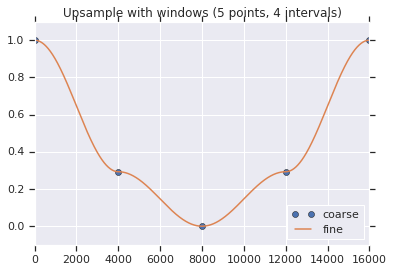

In [0]:
n_coarse = 5
n_fine = 16000

coarse = 1.0 - np.sin(np.linspace(0, np.pi, n_coarse))[np.newaxis, :, np.newaxis]
fine = ddsp.core.upsample_with_windows(f32(coarse), n_fine, add_endpoint=False)

plt.plot(np.linspace(0, n_fine, n_coarse), coarse[0, :, 0], 'o', label='coarse')
plt.plot(np.linspace(0, n_fine, n_fine), fine.eval()[0, :, 0], label='fine')
plt.title('Upsample with windows ({} points, {} intervals)'.format(n_coarse, n_coarse - 1))
plt.legend(loc='lower right')
plt.ylim(-0.1, 1.1)

`add_endpoint` has the same behavior and defaults to True, as it matches the behavior of `fft_convolve`.

(-0.1, 1.1)

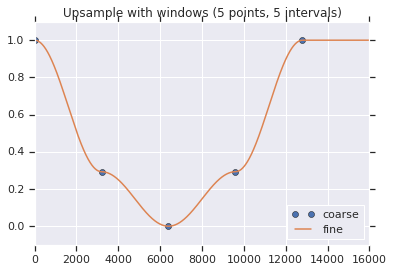

In [0]:
coarse = 1.0 - np.sin(np.linspace(0, np.pi, n_coarse))[np.newaxis, :, np.newaxis]
fine = ddsp.core.upsample_with_windows(f32(coarse), n_fine)

n_intervals = (n_coarse - 1)
n_forward = int(n_fine / n_coarse * n_intervals)
plt.plot(np.linspace(0, n_forward, n_coarse), coarse[0, :, 0], 'o', label='coarse')
plt.plot(np.linspace(0, n_fine, n_fine), fine.eval()[0, :, 0], label='fine')
plt.title('Upsample with windows ({} points, {} intervals)'.format(n_coarse, n_coarse))
plt.legend(loc='lower right')
plt.ylim(-0.1, 1.1)

You can also call `upsample_with_windows()` by calling `resample(method='window')`.

(-0.1, 1.1)

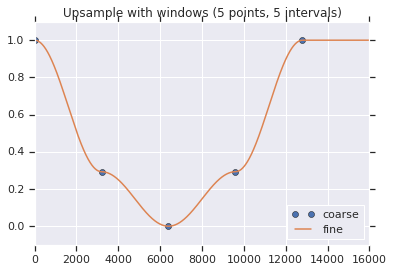

In [0]:
fine = ddsp.resample(f32(coarse), n_fine, method='window')

plt.plot(np.linspace(0, n_forward, n_coarse), coarse[0, :, 0], 'o', label='coarse')
plt.plot(np.linspace(0, n_fine, n_fine), fine.eval()[0, :, 0], label='fine')
plt.title('Upsample with windows ({} points, {} intervals)'.format(n_coarse, n_coarse))
plt.legend(loc='lower right')
plt.ylim(-0.1, 1.1)

The Hann window transitions are smooth like bicubic, but more gradual and don't overshoot.

(-0.1, 1.1)

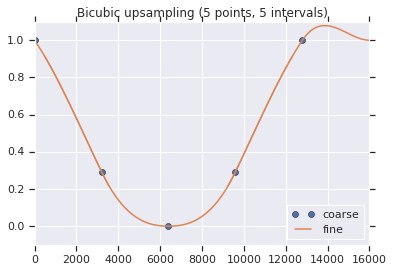

In [0]:
fine = ddsp.resample(f32(coarse), n_fine, method='cubic')

plt.plot(np.linspace(0, n_forward, n_coarse), coarse[0, :, 0], 'o', label='coarse')
plt.plot(np.linspace(0, n_fine, n_fine), fine.eval()[0, :, 0], label='fine')
plt.title('Bicubic upsampling ({} points, {} intervals)'.format(n_coarse, n_coarse))
plt.legend(loc='lower right')
plt.ylim(-0.1, 1.1)

# Synthesis

## `oscillator_bank()`



Synthesize audio with an array of sinusoidal oscillators. Frequencies and amplitudes must be provided at audio rate.


### Ex: Simple harmonic sound

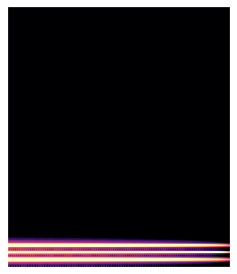

In [0]:
sample_rate = 16000
n_samples = int(sample_rate * 4.0)
n_components = 3

# Amplitudes [n_batch, n_samples, n_components].
# Linearly decay in time.
amps = np.linspace(0.3, 0.0, n_samples)
amps = np.tile(amps[np.newaxis, :, np.newaxis], [1, 1, n_components])

# Frequencies in Hz [n_batch, n_samples, n_components].
frequencies = np.ones([1, n_samples, 1]) * np.array([[[220, 440, 660]]])

# Sythesize.
audio = ddsp.oscillator_bank(frequencies, amps, sample_rate)

# Listen.
audio_np = audio.eval()[0, :]
play(audio_np)
specplot(audio_np)

### Ex: Random frequencies

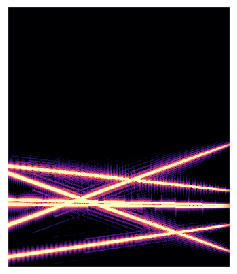

In [0]:
sample_rate = 16000
n_samples = int(sample_rate * 4.0)
n_components = 6
n_frames = 100

# Amplitudes [n_batch, n_samples, n_components].
# Linearly decay in time.
amps = np.linspace(0.3, 0.0, n_samples)
amps = np.tile(amps[np.newaxis, :, np.newaxis], [1, 1, n_components])

# Frequencies in Hz [n_batch, n_samples, n_components].
frequencies = []
for _ in range(n_components):
  f_start = np.random.uniform(20, 4000)
  f_end = np.random.uniform(20, 4000)
  frequencies.append(np.linspace(f_start, f_end, n_frames))
frequencies = np.stack(frequencies).T[np.newaxis, ...] 
frequencies = ddsp.resample(frequencies, n_samples)

# Sythesize.
audio = ddsp.oscillator_bank(f32(frequencies), f32(amps), sample_rate)

# Listen.
audio_np = audio.eval()[0, :]
play(audio_np)
specplot(audio_np)

### Ex: Swarm of sinusoids

Just for fun...

In [0]:
def smooth(x, window_size=2000):
  """Smooth signal with box filter. For random frequency modulation."""
  window = np.ones(window_size) / window_size
  return np.convolve(window, x, mode='same')

sample_rate = 16000
n_samples = int(sample_rate * 6.0)
n_components = 100

# Time points for the frequency ramp.
n_start = int(sample_rate * 1.5)
n_stop = int(sample_rate * 4.0)
n_ramp = n_stop - n_start
n_level = n_samples - n_stop

# Amplitudes [n_batch, n_samples, n_components].
# Decrease amplitude for higher components.
amps = np.ones([1, n_samples, 1])
amps = amps * np.logspace(0, -2, n_components)[np.newaxis, np.newaxis, :]
# Fade in at the start, out at end.
amps[:, :n_start, :] *= np.logspace(-2, 0, n_start)[np.newaxis, :, np.newaxis]
amps[:, -2000:, :] *= np.logspace(0, -2, 2000)[np.newaxis, :, np.newaxis]

# Frequencies in Hz [n_batch, n_samples, n_components].
# Sweep frequencies from random initial frequenices to fixed final frequencies.
freq_initial = np.random.uniform(low=240.0, high=280.0, size=10)
harmonics = np.arange(1, 11)
f0 = np.array([0.5, 1, 1, 2.5, 3, 3.5, 4, 4.5, 5, 5.25])
freq_final = 150 * f0

# Treat each frequency sweep separately.
frequencies = []

for i, f in zip(freq_initial, freq_final):
  # Sweep the frequency.
  freq = np.concatenate(
      [i * np.ones(n_start), np.linspace(i, f, n_ramp), f * np.ones(n_level),])
  # Modulate the frequency.
  d_freq = smooth(np.concatenate([
      np.random.uniform(low=0.1, high=1.9, size=n_start),
      np.random.uniform(low=0.5, high=1.5, size=n_ramp + n_level),
  ]))
  freq *= d_freq
  # Add harmonics for each fundamental.
  frequencies.append([freq * h for h in harmonics])

# Rearrange to [n_batch, n_samples, n_components].
frequencies = np.transpose(np.stack(frequencies), (2, 1, 0))
frequencies = np.reshape(frequencies, [1, n_samples, -1])

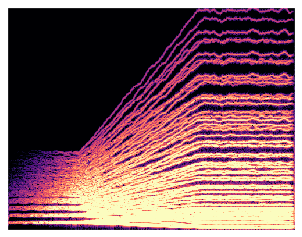

In [0]:
# Sythesize.
audio = ddsp.oscillator_bank(frequencies, amps, sample_rate)

# Listen.
audio_np = audio.eval()[0, :]
audio_np /= np.abs(audio_np).max()
play(audio_np)
specplot(audio_np)

## `linear_lookup()`



Synthesize audio with an array of sinusoidal oscillators. Frequencies and amplitudes must be provided at audio rate.


### Ex: Sinusoidal lookup

As a simple example, lookup from a sin-wave wavetable produces a sin wave at the lookup frequency

In [0]:
n_samples = 16000
n_wavetable = 2048
n_cycles = 440

# Sin wave
wavetable = tf.sin(tf.linspace(0.0, 2.0 * np.pi, n_wavetable))
wavetable = wavetable[tf.newaxis, tf.newaxis, :]

phase = tf.linspace(0.0, n_cycles, n_samples) % 1.0
phase = phase[tf.newaxis, :, tf.newaxis]

output = ddsp.linear_lookup(phase, wavetable)
target = np.sin(np.linspace(0.0, 2.0 * np.pi * n_cycles, n_samples))

Target


Output


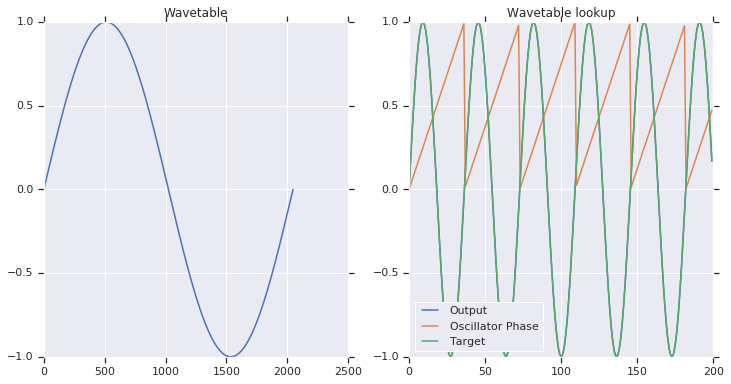

In [0]:
output_np = output.eval()[0]
phase_np = phase.eval()[0, :, 0]

# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.plot(wavetable.eval()[0, 0, :])
plt.title('Wavetable')

plt.subplot(122)
plt.plot(output_np[:200], label='Output')
plt.plot(phase_np[:200], label='Oscillator Phase')
plt.plot(target[:200], label='Target')
plt.title('Wavetable lookup')
plt.legend(loc='lower left')

print('Target')
play(target)
print('Output')
play(output_np)

There are small aritfacts due to the linear interpolation and implicit resampling of the signal

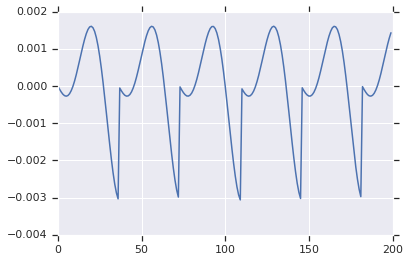

In [0]:
plt.plot(target[:200] - output_np[:200])

You can also use any arbitrary waveform as the lookup signal to get more interesting outputs

Output


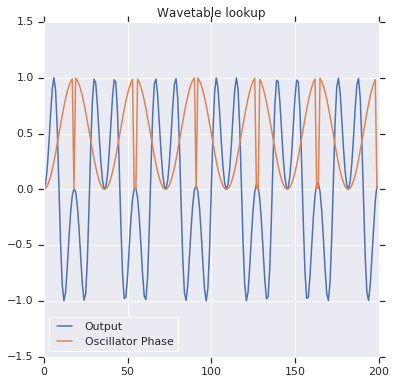

In [0]:
modulation =  tf.linspace(0.0, 0.5, n_samples)
modulation = modulation[tf.newaxis, :, tf.newaxis]
phase2 = (tf.sin(np.pi * phase) + modulation)**2.0 % 1.0
output2 = ddsp.linear_lookup(phase2, wavetable)

output_np2 = output2.eval()[0]
phase_np2 = phase2.eval()[0, :, 0]

# Plot the results
plt.figure(figsize=(6, 6))

plt.plot(output_np2[:200], label='Output')
plt.plot(phase_np2[:200], label='Oscillator Phase')
plt.title('Wavetable lookup')
plt.ylim(-1.5, 1.5)
plt.legend(loc='lower left')

print('Output')
play(output_np2)

### Ex: Multiple Wavetables

You can also use multiple wavetables (one for each timestep)

In [0]:
n_samples = 16000
n_wavetable = 2048
n_cycles = 440

phase = tf.linspace(0.0, n_cycles, n_samples) % 1.0
phase = phase[tf.newaxis, :, tf.newaxis]

# Sin wave
wavetable_sin = tf.sin(tf.linspace(0.0, 2.0 * np.pi, n_wavetable))
wavetable_sin = wavetable_sin[tf.newaxis, tf.newaxis, :]

# Square wave
wavetable_square = tf.cast(wavetable_sin > 0.0, tf.float32) * 2.0 - 1.0

wavetables = tf.concat([wavetable_square, 
                        wavetable_sin], axis=1)
wavetables = tf.image.resize(wavetables[:, :, tf.newaxis, :], 
                             [n_samples, 1],
                              align_corners=True)[:, :, 0, :]

output_multiwave = ddsp.linear_lookup(phase, wavetables)

Output


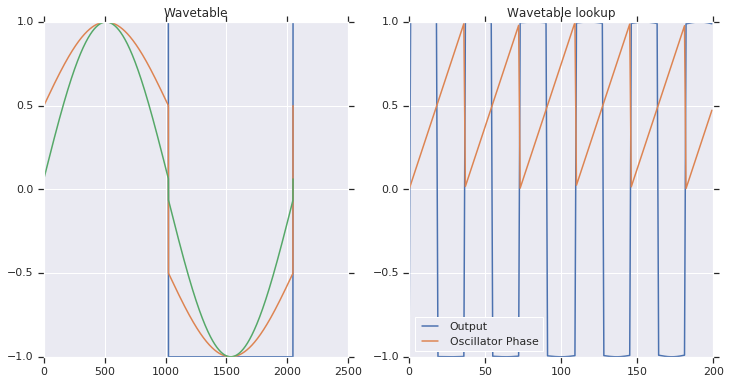

In [0]:
wavetables_np = wavetables.eval()[0]
output_multiwave_np = output_multiwave.eval()[0]

# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.plot(wavetables_np[0, :])
plt.plot(wavetables_np[8000, :])
plt.plot(wavetables_np[15000, :])
plt.title('Wavetable')

plt.subplot(122)
plt.plot(output_multiwave_np[:200], label='Output')
plt.plot(phase_np[:200], label='Oscillator Phase')
plt.title('Wavetable lookup')
plt.legend(loc='lower left')

print('Output')
play(output_multiwave_np)